## A region-level Difference-in-Differences analysis of the step-up in MMP enforcement

<i> Author: Ryan Treves

In [8]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
import yaml
from pathlib import Path
from policy_eval import scrape_facility_reports as sr


# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# display all columns
pd.set_option('display.max_columns', None)

# turn off warning messages
warnings.filterwarnings('ignore')

In [3]:
# for now, import & use utility functions sitting in 'main.py'
from policy_eval import main

In [5]:
# read in configuration file
with open(Path().resolve().parent / 'config.yml', 'r') as file:
    configs = yaml.safe_load(file)
data_path = Path(configs['CIWQS_data_path'])

# read in data
violations = pd.read_excel(data_path / 'violations_export_2021-10-26.xlsx', dtype={'FACILITY_ID': str},
                           parse_dates=['OCCURRED ON', 'EFFECTIVE DATE', 'TERMINATION DATE'], date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements = pd.read_csv(data_path / 'enf_actions_export.csv',
                           dtype={'FACILITY ID': object},
                           parse_dates=['DATE OF OLDEST VIOLATION LINKED TO ENFORCEMENT ACTION', 'EFFECTIVE DATE.1', 'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE'],
                           date_parser=lambda x: pd.to_datetime(x, errors='coerce'))
enforcements.rename(columns={'FACILITY ID': 'FACILITY_ID'}, inplace=True)

In [6]:
# Remove all enforcements with no MMP violations
enforcements = main.clean_enforcements(enforcements, mmp_only=True)

# Remove all dismissed and exempt violations
violations = main.clean_violations(violations, mmp_only=True, effluent_only=True)

### Treatment regions
Regions 2, 3, 4, 5S, and 5F participated in the 2008 MMP enforcement push.

In [12]:
mmp_enforcements = enforcements[(enforcements['TOTAL MMP VIOLATIONS #'] > 0)]
mmp_enforcements['estimated_enforcement_date'] = mmp_enforcements[['EFFECTIVE DATE.1', 'ACL ISSUANCE DATE', 'EPL ISSUANCE DATE']].min(axis=1)

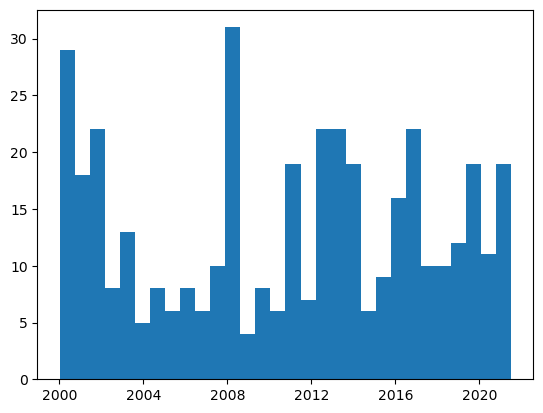

In [13]:
plt.style.use('default')
plt.hist(mmp_enforcements[mmp_enforcements['REGION']=='2']['estimated_enforcement_date'], bins=30);

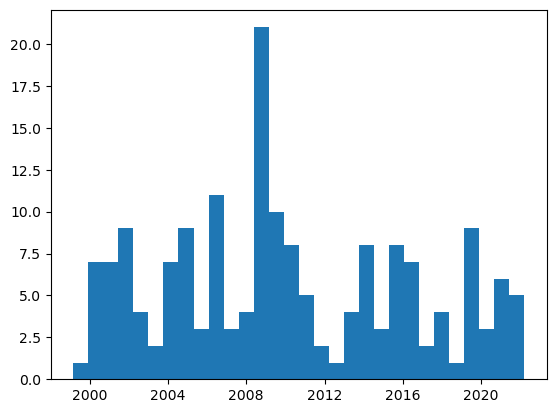

In [15]:
plt.hist(mmp_enforcements[mmp_enforcements['REGION']=='3']['estimated_enforcement_date'], bins=30);

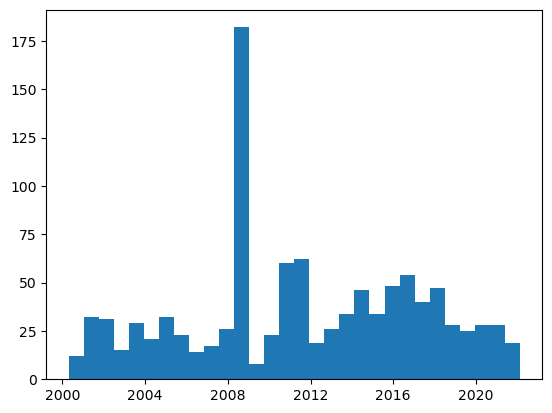

In [17]:
plt.hist(mmp_enforcements[mmp_enforcements['REGION']=='4']['estimated_enforcement_date'], bins=30);

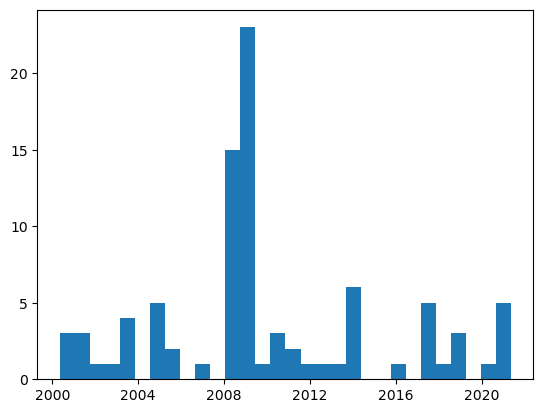

In [19]:
plt.hist(mmp_enforcements[mmp_enforcements['REGION']=='5F']['estimated_enforcement_date'], bins=30);

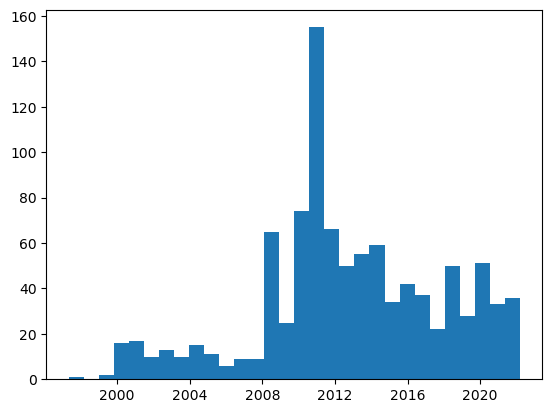

In [21]:
plt.hist(mmp_enforcements[mmp_enforcements['REGION']=='5S']['estimated_enforcement_date'], bins=30);

Based on the enforcement date distributions, assigning the treatment date of 2008 Q4 (4th quarter of 2008) to all treatment regions seems reasonable.

We only want to include facilities in our treatment group which received enforcements as a part of the 2008 enforcement push:

In [23]:
treatment_facilities = list(mmp_enforcements[(mmp_enforcements['REGION'].apply(lambda x: x in ['2', '3', '4', '5F', '5S'])) &
                                             (mmp_enforcements['estimated_enforcement_date'] > pd.to_datetime('2008-01-01')) &
                                             (mmp_enforcements['estimated_enforcement_date'] < pd.to_datetime('2009-01-22'))]['FACILITY_ID'].unique())

### Comparison regions
Regions 8 and 9 have consistently enforced MMP since 2000.

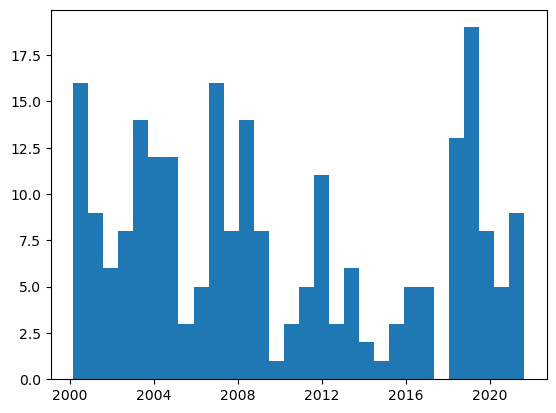

In [24]:
plt.hist(mmp_enforcements[mmp_enforcements['REGION'].apply(lambda x: x in ['8', '9'])]['estimated_enforcement_date'], bins=30);

### Excluded regions
Regions 1, 6, and 7 are excluded.
Although region 7 consistently enforced MMP since 2000, there was a spike in MMP enforcements in 2008 that may bias our estimates.
TODO: explain why we exclude regions 1, 6

In [25]:
treatment_violations = violations[violations['FACILITY_ID'].apply(lambda x: x in treatment_facilities)]
comparison_violations = violations[violations['VIOLATED FACILITY REGION'].apply(lambda x: str(x) in ['8', '9'])]

comparison_violations['violation_quarter'] = comparison_violations['OCCURRED ON'].dt.to_period('Q').astype(int)
treatment_violations['violation_quarter'] = treatment_violations['OCCURRED ON'].dt.to_period('Q').astype(int)

In [26]:
comparison_violations['violation_year'] = comparison_violations['OCCURRED ON'].dt.year
treatment_violations['violation_year'] = treatment_violations['OCCURRED ON'].dt.year

Our outcome depends on knowing how many facilities in our groups are active in NPDES at any given time. To do this, we need to determine when a facility entered and exited the population. Here, I define entering population as being issued a NPDES permit. Defining when facilities exit the population is less straightforward: a facility's NPDES permit may expire, but until the permit is renewed or terminated, the permittee may still be discharging and is still regulated under NPDES. Furthermore, the `TERMINATION DATE` listed on a violation record may not actually reflect exit of the population, as the permittee may have switched NPDES subprograms (e.g., from NPDESWW to NPDESNONMUNIPRCS, as in the case of `FACILITY_ID` 261701). Thus, as a heuristic until we can come up with a better way or do everything by hand, I define the date when a facility exists the population as the expiration date of the facility's last NPDES permit, or the latest permit termination date (`TERMINATION DATE`) in the violations record, whichever is latest. In the case that we don't have a permit termination date, the facility is assumed to still be active, and is assigned an estimated exit date of NA. In some cases, violations will still appear after this date, however, they seem to be due to late reporting in all cases.

In [27]:
# Load facility reports for facilities in our treatment and comparison regions
treatment_fac_reports = sr.scrape_facility_reports(treatment_facilities, verbose=True)
comparison_fac_reports = sr.scrape_facility_reports(violations[violations['VIOLATED FACILITY REGION'].apply(lambda x: str(x) in ['8', '9'])]['FACILITY_ID'].unique(), verbose=True)

In [28]:
# Extract entrance and exit dates for each facility, and join them with the violations table
treatment_violations = main.get_facility_entrance_exit(treatment_fac_reports, treatment_violations)
comparison_violations = main.get_facility_entrance_exit(comparison_fac_reports, comparison_violations)

In order to not violate our assumptions about group composition, we need to condition on a facility being present in the population (i.e., having an active NPDES permit) within our period of analysis. Here, I define that period as 2004-2012.

In [107]:
treatment_violations = treatment_violations[
                                # Enter the population by 2004
                                (treatment_violations['estimated_entrance_date'] <= pd.to_datetime('2004-01-01')) &
                                # Do not exit the population before 2013
                                ~(treatment_violations['estimated_exit_date'] <= pd.to_datetime('2012-12-31'))]
comparison_violations = comparison_violations[
                                # Enter the population by 2004
                                (comparison_violations['estimated_entrance_date'] <= pd.to_datetime('2004-01-01')) &
                                # Do not exit the population before 2013
                                ~(comparison_violations['estimated_exit_date'] <= pd.to_datetime('2012-12-31'))]
treatment_facilities = list(treatment_violations['FACILITY_ID'].unique())
comparison_facilities = list(comparison_violations['FACILITY_ID'].unique())

What is the effect on our group sizes?

In [108]:
print(len(treatment_facilities))
print(len(comparison_facilities))

180
59


### Preprocessing data for analysis in R

In [113]:
def regression_preprocess(treatment_viols, comparison_viols, outcome, time_bounds=None, timescale='quarterly'):
    """
    :param treatment_viols: pd.DataFrame, table of violations from the treatment group
    :param comparison_viols: pd.DataFrame, table of violations from the comparison group
    :param outcome: str, outcome of interest, options 'violation_rate', 'total_violations'
    :param include_reporting_violations: bool, whether to include reporting violations (default True)
    :param time_bounds: optional two-element array-like of string dates, for restricting pre- and post-period for analysis.
    e.g., ['2005-01-01', '2012-01-01']
    :param timescale: str, unit of time for analysis, options 'quarterly', 'yearly', default 'quarterly'
    :return: processed pd.DataFrame with analysis data
    :return: model output, type statsmodels.regression.linear_model.OLSResults
    """

    time_var = 'violation_quarter'
    if timescale == 'yearly':
        time_var = 'violation_year'

    # Aggregate violation rates across regions
    analysis_table_by_region = pd.DataFrame()
    for region in ['2', '3', '4', '5F', '5S', '8', '9']:
        if region in ['8', '9']:
            region_violations = comparison_viols[
                comparison_viols['VIOLATED FACILITY REGION'].astype(str) == region]
        else:
            region_violations = treatment_viols[treatment_viols['VIOLATED FACILITY REGION'].astype(str) == region]
        # Calculate outcome data
        if outcome == 'violation_rate':
            # Calculate number of violating facilities each quarter
            region_grouped = region_violations.groupby(time_var, as_index=False).agg(
                n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
            # Calculate number of active facilities each quarter
            if time_var == 'violation_year':
                region_grouped['n_facilities_active'] = region_grouped[time_var].apply(lambda x: len(
                    # Facility has to have enrolled in NPDES on or before the year in question
                    region_violations[(region_violations['estimated_entrance_date'].dt.year <= x) &
                                      # and NOT have a permit that has expired before the year in question
                                      (~(region_violations['estimated_exit_date'].dt.year < x))].drop_duplicates('FACILITY_ID')))
            else:
                region_grouped['n_facilities_active'] = region_grouped[time_var].apply(lambda x: len(
                    # Facility has to have enrolled in NPDES on or before the quarter in question
                    region_violations[(region_violations['estimated_entrance_quarter'] <= x) &
                                      # and NOT have a permit that has expired by the quarter in question
                                      (~(region_violations['estimated_exit_quarter'] <= x))].drop_duplicates('FACILITY_ID')))
            # Divide violating # by active #
            region_grouped['violation_rate'] = region_grouped['n_violating_facilities'] / region_grouped[
                'n_facilities_active']

        if outcome == 'total_violations':
            region_grouped = region_violations.groupby(time_var, as_index=False).agg(
                total_violations=pd.NamedAgg(column='VIOLATION ID (VID)', aggfunc=lambda x: x.nunique()))

        region_grouped['Region'] = region

        # Assign dummy treatment variable by region
        if region in ['8', '9']:
            region_grouped['treatment'] = 0
        else:
            region_grouped['treatment'] = 1

        analysis_table_by_region = pd.concat([analysis_table_by_region, region_grouped])

    # Create dummy variable indicating post-treatment
    if timescale == 'quarterly':
        analysis_table_by_region['post'] = (analysis_table_by_region[time_var] > 155).astype(int)
    if timescale == 'yearly':
        analysis_table_by_region['post'] = (analysis_table_by_region[time_var] > 2008).astype(int)

    # Optional, set time bounds on analysis
    if time_bounds is not None:
        if timescale == 'yearly':
            analysis_table_by_region = analysis_table_by_region[
                (analysis_table_by_region[time_var] >= pd.to_datetime(time_bounds[0]).year) &
                (analysis_table_by_region[time_var] <= pd.to_datetime(time_bounds[1]).year)]
        else:
            analysis_table_by_region = analysis_table_by_region[
                (analysis_table_by_region[time_var] >= pd.to_datetime(time_bounds[0]).to_period('Q').ordinal) &
                (analysis_table_by_region[time_var] <= pd.to_datetime(time_bounds[1]).to_period('Q').ordinal)]
    return analysis_table_by_region

In [114]:
# Preprocess and save for analysis in R
regression_preprocess(treatment_violations, comparison_violations,
                      outcome='violation_rate', timescale='yearly').to_csv('viols_preprocessed.csv')

### Which DiD assumptions are we violating, or potentially violating, in this analysis?
- Parallel pre-trends: depending on the timescale, one may deem this assumption violated. Looking at the full pre-treatment period 2000-2008, treatment and comparison groups have a similar trend in the quarterly percentage of facilities violating. However, looking only at the period 2005-2008, the treatment group has a declining trend in this statistic, while the comparison group has an increasing trend.

In [115]:
# Calculate number of violating facilities each quarter, by region
comparison_grouped_quarterly = comparison_violations.groupby(['violation_quarter', 'VIOLATED FACILITY REGION'], as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
treatment_grouped_quarterly = treatment_violations.groupby(['violation_quarter', 'VIOLATED FACILITY REGION'], as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

# Calculate number of active facilities in each region each quarter
comparison_grouped_quarterly['n_facilities_active'] = np.nan
for i in range(0, len(comparison_grouped_quarterly)):
    comparison_grouped_quarterly['n_facilities_active'].iloc[i] =\
        len(
        comparison_violations[
        # Facility has to be in the region
            (comparison_violations['VIOLATED FACILITY REGION'] == comparison_grouped_quarterly['VIOLATED FACILITY REGION'].iloc[i]) &
            # Facility has to have enrolled in NPDES on or before the quarter in question
            (comparison_violations['estimated_entrance_quarter'] <= comparison_grouped_quarterly['violation_quarter'].iloc[i]) &
            # and NOT have a permit that has expired by the quarter in question
            (~(comparison_violations['estimated_exit_quarter'] <= comparison_grouped_quarterly['violation_quarter'].iloc[i]))].drop_duplicates('FACILITY_ID'))

In [116]:
treatment_grouped_quarterly['n_facilities_active'] = np.nan
for i in range(0, len(treatment_grouped_quarterly)):
    treatment_grouped_quarterly['n_facilities_active'].iloc[i] =\
        len(
        treatment_violations[
        # Facility has to be in the region
            (treatment_violations['VIOLATED FACILITY REGION'] == treatment_grouped_quarterly['VIOLATED FACILITY REGION'].iloc[i]) &
            # Facility has to have enrolled in NPDES on or before the quarter in question
            (treatment_violations['estimated_entrance_quarter'] <= treatment_grouped_quarterly['violation_quarter'].iloc[i]) &
            # and NOT have a permit that has expired by the quarter in question
            (~(treatment_violations['estimated_exit_quarter'] <= treatment_grouped_quarterly['violation_quarter'].iloc[i]))].drop_duplicates('FACILITY_ID'))

In [117]:
# Divide violating # by active #
comparison_grouped_quarterly['violation_rate'] = comparison_grouped_quarterly['n_violating_facilities'] / comparison_grouped_quarterly[
    'n_facilities_active']
treatment_grouped_quarterly['violation_rate'] = treatment_grouped_quarterly['n_violating_facilities'] / treatment_grouped_quarterly[
    'n_facilities_active']

In [118]:
# Average violation rates across regions
comparison_grouped_quarterly = comparison_grouped_quarterly.groupby('violation_quarter', as_index=False).agg(n_facilities_active=pd.NamedAgg(column='n_facilities_active', aggfunc=lambda x: x.sum()), mean_violation_rate=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.mean()), violation_rate_se=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.sem()))
treatment_grouped_quarterly = treatment_grouped_quarterly.groupby('violation_quarter', as_index=False).agg(n_facilities_active=pd.NamedAgg(column='n_facilities_active', aggfunc=lambda x: x.sum()), mean_violation_rate=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.mean()), violation_rate_se=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.sem()))

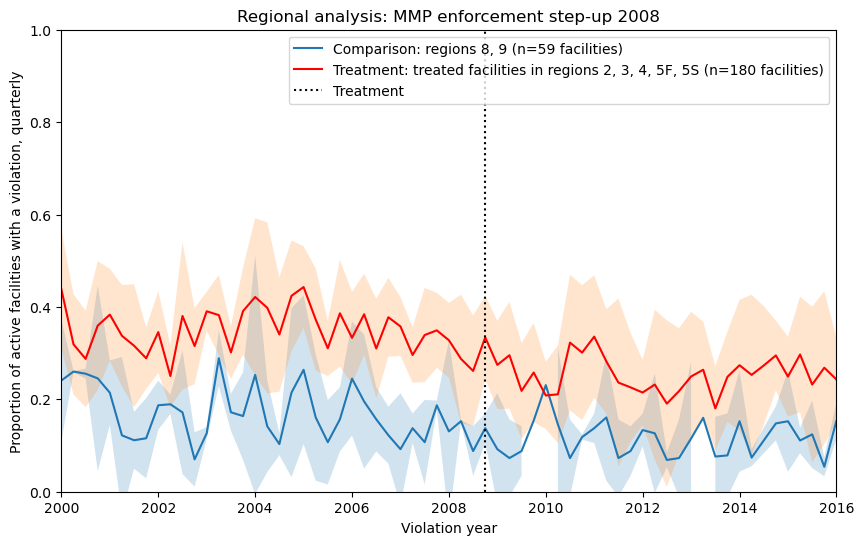

In [119]:
# Plot
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(comparison_grouped_quarterly['violation_quarter'], comparison_grouped_quarterly['mean_violation_rate'],
         label='Comparison: regions 8, 9 (n=' + str(len(comparison_violations.drop_duplicates('FACILITY_ID'))) + ' facilities)');
plt.plot(treatment_grouped_quarterly['violation_quarter'], treatment_grouped_quarterly['mean_violation_rate'],
         label='Treatment: treated facilities in regions 2, 3, 4, 5F, 5S (n=' + str(len(treatment_violations.drop_duplicates('FACILITY_ID'))) + ' facilities)', color='red');

plt.fill_between(comparison_grouped_quarterly['violation_quarter'], comparison_grouped_quarterly['mean_violation_rate']-1.96*comparison_grouped_quarterly['violation_rate_se'], comparison_grouped_quarterly['mean_violation_rate']+1.96*comparison_grouped_quarterly['violation_rate_se'], alpha=0.2)
plt.fill_between(treatment_grouped_quarterly['violation_quarter'], treatment_grouped_quarterly['mean_violation_rate']-1.96*treatment_grouped_quarterly['violation_rate_se'], treatment_grouped_quarterly['mean_violation_rate']+1.96*treatment_grouped_quarterly['violation_rate_se'], alpha=0.2)

plt.axvline(x=155, linestyle=':', color='black', label='Treatment')
plt.ylabel('Proportion of active facilities with a violation, quarterly')
plt.ylim((0, 1))
plt.xlim((120, 184))
plt.xticks(list(range(120, 192, 8)), [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016])
plt.xlabel('Violation year')
plt.title('Regional analysis: MMP enforcement step-up 2008')
plt.legend();

Same plot, but yearly:

In [120]:
# Calculate number of violating facilities each year, by region
comparison_grouped_yearly = comparison_violations.groupby(['violation_year', 'VIOLATED FACILITY REGION'], as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))
treatment_grouped_yearly = treatment_violations.groupby(['violation_year', 'VIOLATED FACILITY REGION'], as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

# Calculate number of active facilities in each region each year
comparison_grouped_yearly['n_facilities_active'] = np.nan
for i in range(0, len(comparison_grouped_yearly)):
    comparison_grouped_yearly['n_facilities_active'].iloc[i] =\
        len(
        comparison_violations[
        # Facility has to be in the region
            (comparison_violations['VIOLATED FACILITY REGION'] == comparison_grouped_yearly['VIOLATED FACILITY REGION'].iloc[i]) &
            # Facility has to have enrolled in NPDES on or before the year in question
            (comparison_violations['estimated_entrance_date'].dt.year <= comparison_grouped_yearly['violation_year'].iloc[i]) &
            # and NOT have a permit that has expired by the year in question
            (~(comparison_violations['estimated_exit_date'].dt.year <= comparison_grouped_yearly['violation_year'].iloc[i]))].drop_duplicates('FACILITY_ID'))

treatment_grouped_yearly['n_facilities_active'] = np.nan
for i in range(0, len(treatment_grouped_yearly)):
    treatment_grouped_yearly['n_facilities_active'].iloc[i] =\
        len(
        treatment_violations[
        # Facility has to be in the region
            (treatment_violations['VIOLATED FACILITY REGION'] == treatment_grouped_yearly['VIOLATED FACILITY REGION'].iloc[i]) &
            # Facility has to have enrolled in NPDES on or before the year in question
            (treatment_violations['estimated_entrance_date'].dt.year <= treatment_grouped_yearly['violation_year'].iloc[i]) &
            # and NOT have a permit that has expired by the year in question
            (~(treatment_violations['estimated_exit_date'].dt.year <= treatment_grouped_yearly['violation_year'].iloc[i]))].drop_duplicates('FACILITY_ID'))

# Divide violating # by active #
comparison_grouped_yearly['violation_rate'] = comparison_grouped_yearly['n_violating_facilities'] / comparison_grouped_yearly[
    'n_facilities_active']
treatment_grouped_yearly['violation_rate'] = treatment_grouped_yearly['n_violating_facilities'] / treatment_grouped_yearly[
    'n_facilities_active']

In [121]:
# Average violation rates across regions
comparison_grouped_yearly = comparison_grouped_yearly.groupby('violation_year', as_index=False).agg(n_facilities_active=pd.NamedAgg(column='n_facilities_active', aggfunc=lambda x: x.sum()), mean_violation_rate=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.mean()), violation_rate_se=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.sem()))
treatment_grouped_yearly = treatment_grouped_yearly.groupby('violation_year', as_index=False).agg(n_facilities_active=pd.NamedAgg(column='n_facilities_active', aggfunc=lambda x: x.sum()), mean_violation_rate=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.mean()), violation_rate_se=pd.NamedAgg(column='violation_rate', aggfunc=lambda x: x.sem()))

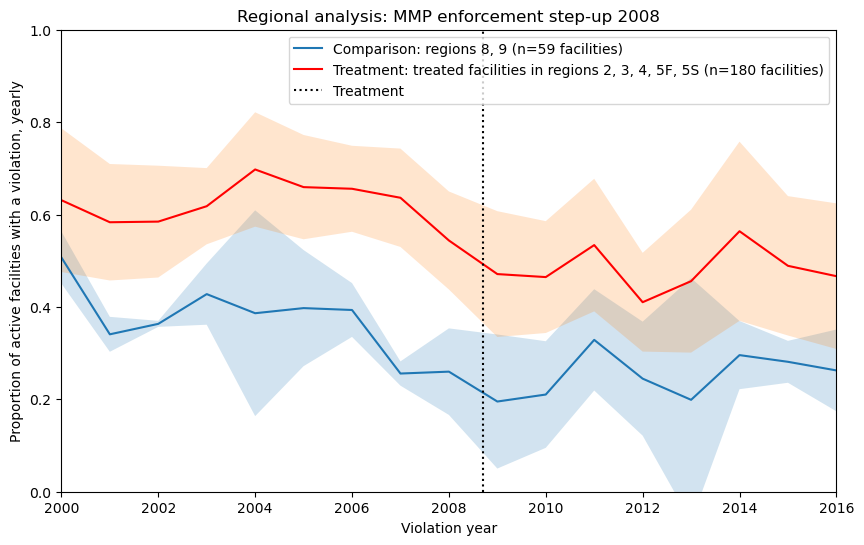

In [122]:
# Plot
plt.style.use('default')
plt.figure(figsize=(10, 6))
plt.plot(comparison_grouped_yearly['violation_year'], comparison_grouped_yearly['mean_violation_rate'],
         label='Comparison: regions 8, 9 (n=' + str(len(comparison_violations.drop_duplicates('FACILITY_ID'))) + ' facilities)');
plt.plot(treatment_grouped_yearly['violation_year'], treatment_grouped_yearly['mean_violation_rate'],
         label='Treatment: treated facilities in regions 2, 3, 4, 5F, 5S (n=' + str(len(treatment_violations.drop_duplicates('FACILITY_ID'))) + ' facilities)', color='red');

plt.fill_between(comparison_grouped_yearly['violation_year'], comparison_grouped_yearly['mean_violation_rate']-1.96*comparison_grouped_yearly['violation_rate_se'], comparison_grouped_yearly['mean_violation_rate']+1.96*comparison_grouped_yearly['violation_rate_se'], alpha=0.2)
plt.fill_between(treatment_grouped_yearly['violation_year'], treatment_grouped_yearly['mean_violation_rate']-1.96*treatment_grouped_yearly['violation_rate_se'], treatment_grouped_yearly['mean_violation_rate']+1.96*treatment_grouped_yearly['violation_rate_se'], alpha=0.2)

plt.axvline(x=2008.7, linestyle=':', color='black', label='Treatment')
plt.ylabel('Proportion of active facilities with a violation, yearly')
plt.ylim((0, 1))
plt.xlim((2000, 2016))
plt.xlabel('Violation year')
plt.title('Regional analysis: MMP enforcement step-up 2008')
plt.legend();

What facility-level differences do we see between the two groups?

In [123]:
# This function takes in a comparison group, treatment group, and a column name,
# and returns the top n values of the column in order of the absolute difference
# in composition of the two groups. Streamlines compositional analysis.
def compare_composition(data_a, data_b, column, top_n=3):
    A = pd.DataFrame(data_a[column].value_counts(normalize=True)).rename(columns={column: 'Comparison'})
    B = pd.DataFrame(data_b[column].value_counts(normalize=True)).rename(columns={column: 'Treatment'})
    results = pd.concat([A, B], axis=1)
    results['diff'] = np.abs(results['Comparison'] - results['Treatment'])
    results = results.apply(lambda x: x.round(2))
    results.sort_values(by='diff', inplace=True, ascending=False)
    results = results.reset_index(names='Value').set_index(pd.Index([column] * len(results)))
    return results.head(top_n)

In [124]:
facility_results = pd.DataFrame()
for column in ['AGENCY TYPE', 'PROGRAM', 'MAJOR-MINOR', 'VIOLATED FACILITY REGION', 'VIOLATION TYPE', 'MMP TYPE']:
    facility_results = pd.concat(
        [facility_results, compare_composition(comparison_violations.drop_duplicates('FACILITY_ID'),
                                               treatment_violations.drop_duplicates('FACILITY_ID'), column)])
facility_results.sort_values(by='diff', ascending=False, inplace=True)
facility_results

,Value,Comparison,Treatment,diff
MMP TYPE,Chronic,0.64,0.21,0.43
MMP TYPE,Serious,0.36,0.79,0.43
MAJOR-MINOR,Major,0.66,0.49,0.17
MAJOR-MINOR,Minor,0.34,0.51,0.17
PROGRAM,NPDNONMUNIPRCS,0.17,0.26,0.09
AGENCY TYPE,City Agency,0.22,0.30,0.08
PROGRAM,NPDMUNIOTH,0.03,0.12,0.08
AGENCY TYPE,Special District,0.25,0.20,0.06
PROGRAM,NPDMUNILRG,0.46,0.41,0.05
AGENCY TYPE,Privately-Owned Business,0.39,0.41,0.02


### Addendum: Investigating dropout pattern in region 4
If we don't condition on presence in the population throughout the analysis period, we get a puzzling triangular pattern in active facilities in region 4 in our treatment group (see MMP running notes and SWRCB meeting notes). What about producing a similar plot, not conditional on receiving an EPL? (i.e., all facilities in these regions, not just treatment / comparison)

In [ ]:
region_4_fac_reports = sr.scrape_facility_reports(
    violations[violations['VIOLATED FACILITY REGION'] == 4]['FACILITY_ID'].unique(), verbose=True)
region_4_violations = main.get_facility_entrance_exit(region_4_fac_reports,
                                                      violations[violations['VIOLATED FACILITY REGION'] == 4])
region_4_violations['violation_quarter'] = region_4_violations['OCCURRED ON'].dt.to_period('Q').astype(int)

In [ ]:
# Create a flag for general permittee
region_4_violations['General Permittee'] = 'Unknown'
for viol in range(0, len(region_4_violations)):

    # If permit ID is a general permit ID
    if str(region_4_violations['NPDES# CA#'].iloc[viol])[2] == 'G':
        region_4_violations['General Permittee'].iloc[viol] = 'True'

    # If permit ID is an individual permit ID
    elif not pd.isna(region_4_violations['NPDES# CA#'].iloc[viol]):
        region_4_violations['General Permittee'].iloc[viol] = 'False'
r4_grouped_quarterly = region_4_violations.groupby(['violation_quarter', 'General Permittee'], as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

In [ ]:
# Calculate number of active facilities in each region each quarter
r4_grouped_quarterly['n_facilities_active'] = np.nan
for i in range(0, len(r4_grouped_quarterly)):
    r4_grouped_quarterly['n_facilities_active'].iloc[i] = len(
        region_4_violations[
            # Facility has to be in the permit type
            (region_4_violations['General Permittee'] == r4_grouped_quarterly['General Permittee'].iloc[i]) &
            # Facility has to have enrolled in NPDES on or before the quarter in question
            (region_4_violations['estimated_entrance_quarter'] <= r4_grouped_quarterly['violation_quarter'].iloc[i]) &
            # and NOT have a permit that has expired by the quarter in question
            (~(region_4_violations['estimated_exit_quarter'] <= r4_grouped_quarterly['violation_quarter'].iloc[
                i]))].drop_duplicates('FACILITY_ID'))

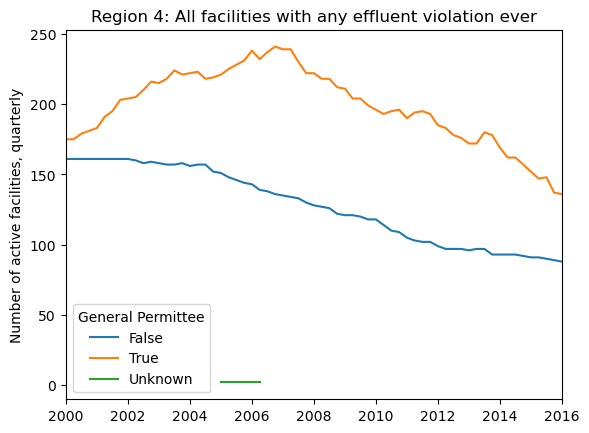

In [135]:
# Plot
plt.style.use('default')
sns.lineplot(data=r4_grouped_quarterly, x='violation_quarter', y='n_facilities_active', hue='General Permittee')
plt.xlabel('')
plt.ylabel('Number of active facilities, quarterly')
plt.xlim((120, 184))
plt.xticks(list(range(120, 192, 8)), [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016])
plt.title('Region 4: All facilities with any effluent violation ever')
plt.savefig('region4plot.png', dpi=200)

What happens if we look at just general permittees, breaking down by permit ID?

In [138]:
region_4_violations_general = region_4_violations[(region_4_violations['General Permittee'] == 'True')]

r4_grouped_general = region_4_violations_general.groupby(['violation_quarter', 'NPDES# CA#'], as_index=False).agg(
    n_violating_facilities=pd.NamedAgg(column='FACILITY_ID', aggfunc=lambda x: x.nunique()))

In [139]:
# Calculate number of active facilities in each region each quarter
r4_grouped_general['n_facilities_active'] = np.nan
for i in range(0, len(r4_grouped_general)):
    r4_grouped_general['n_facilities_active'].iloc[i] = len(
        region_4_violations_general[
            # Facility has to be in the permit type
            (region_4_violations_general['NPDES# CA#'] == r4_grouped_general['NPDES# CA#'].iloc[i]) &
            # Facility has to have enrolled in NPDES on or before the quarter in question
            (region_4_violations_general['estimated_entrance_quarter'] <= r4_grouped_general['violation_quarter'].iloc[i]) &
            # and NOT have a permit that has expired by the quarter in question
            (~(region_4_violations_general['estimated_exit_quarter'] <= r4_grouped_general['violation_quarter'].iloc[
                i]))].drop_duplicates('FACILITY_ID'))

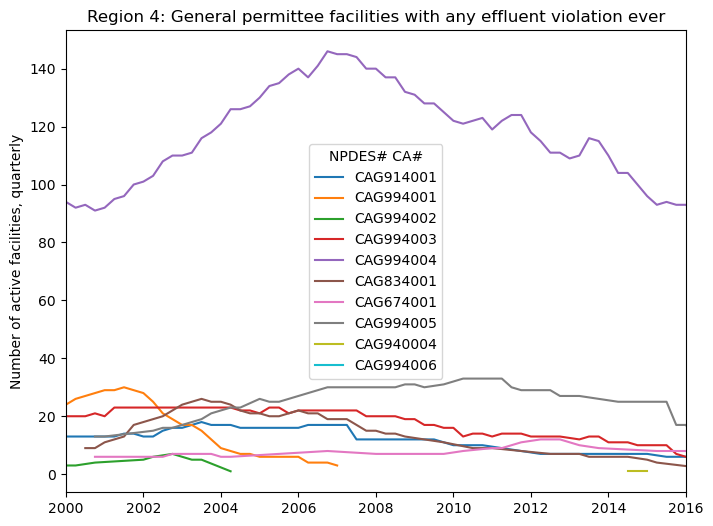

In [143]:
# Plot
plt.style.use('default')
plt.figure(figsize=(8, 6))
sns.lineplot(data=r4_grouped_general, x='violation_quarter', y='n_facilities_active', hue='NPDES# CA#')
plt.xlabel('');
plt.ylabel('Number of active facilities, quarterly')
plt.xlim((120, 184))
plt.xticks(list(range(120, 192, 8)), [2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014, 2016])
plt.title('Region 4: General permittee facilities with any effluent violation ever')
plt.savefig('region4plot.png', dpi=200)